In [2]:
import os
import numpy as np
from datetime import datetime, timedelta, timezone
import xarray as xa
import matplotlib.pyplot as plt
from utils import setup_cmap
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
os.environ["TZ"] = "UTC"

In [20]:
# Setup plotting range
infile = '/glade/derecho/scratch/swei/Dataset/input/obs/caliop_l2_extcoeff/obs.caliop_l2_extcoeff.2019072204.nc4'
# infile = '/glade/work/swei/projects/caliop_opr/JEDI-METplus/output/caliop_merra2/hofx/f00/caliop_l2_extcoeff/hofx.caliop_l2_extcoeff.2019072204.nc4'

In [21]:
def avg_horz_data(data, N):
    if len(data.shape)==2:
        nAlts = data.shape[1]
        nProfiles = data.shape[0]
        nOutProfiles = np.floor(nProfiles/N)
        out = np.zeros((int(nOutProfiles), int(nAlts)))
        for i in range(0, int(nOutProfiles) - 1):
            out[i, :] = np.nanmean(data[i*N:(i+1)*N, :], axis=0)
    elif len(data.shape)==1:
        nProfiles = data.shape[0]
        nOutProfiles = int(np.floor(nProfiles/N))
        out = np.zeros((nOutProfiles))
        for i in range(0, nOutProfiles - 1):
            out[i] = np.nanmean(data[i*N:(i+1)*N], axis=0)
    return out

def uniform_alt_2(max_altitude, old_altitude_array):
    # https://github.com/NASA-DEVELOP/VOCAL/blob/15182377cd9d7de1c03b123e3bbe15b0e959ac80/calipso/plot/uniform_alt_2.py
    D_ALT = 0.03  # spacing is 30 m
    # Altitude indices for high res altitude region (region 2):
    # 288:576
    MID_RES_TOP = 288
    MID_RES_BOT = 576
    alt2 = old_altitude_array[MID_RES_TOP:MID_RES_BOT]
    new_num_bins = int(np.ceil((max_altitude-alt2[0])/D_ALT))
    new_length = int(new_num_bins + len(alt2))
    new_alt = np.zeros(int(new_length))
    new_alt[int(new_num_bins):int(new_length)] = alt2
    upper_altitudes =  (np.arange(new_num_bins) + 1.)*D_ALT
    new_alt[:int(new_num_bins)] = new_alt[int(new_num_bins)] + upper_altitudes[::-1]
    return new_alt

def regrid_lidar(alt, inMatrix, new_alt, method = 'linear'):
    # https://github.com/NASA-DEVELOP/VOCAL/blob/15182377cd9d7de1c03b123e3bbe15b0e959ac80/calipso/plot/regrid_lidar.py
    interpFunc = interpolate.interp1d(alt[::-1], inMatrix[::-1,:], kind=method, 
                                      axis=0, bounds_error=False)
    return interpFunc(new_alt)

In [22]:
# New coloar bar for CALIOP: https://ntrs.nasa.gov/api/citations/20250001533/downloads/Tackett_CCSTM_2025_Ver02.pdf
caliop_bound_flt_lst = [
    9.0e-5,    1.0e-4,    2.0e-4,    3.0e-4,
    4.0e-4,    5.0e-4,    6.0e-4,    7.0e-4,
    8.0e-4,    9.0e-4,    1.0e-3,    1.5e-3,
    2.0e-3,    2.5e-3,    3.0e-3,    3.5e-3,
    4.0e-3,    4.5e-3,    5.0e-3,    5.5e-3,
    6.0e-3,    6.5e-3,    7.0e-3,    7.5e-3,
    8.0e-3,    1.0e-2,    2.0e-2,    3.0e-2,
    4.0e-2,    5.0e-2,    6.0e-2,    7.0e-2,
    8.0e-2,    9.0e-2,    1.0e-1
]
color_idx = np.arange(2, 35)
color_map = setup_cmap('caliop_legacy', color_idx)

In [23]:
meta_ds = xa.open_dataset(infile, group='MetaData')
obsv_ds = xa.open_dataset(infile, group='ObsValue')
# hofx_ds = xa.open_dataset(infile, group='hofx')

In [24]:
nlev = meta_ds.Level.size
nloc = meta_ds.Location.size
npro = int(meta_ds.Location.size / nlev)
nchl = meta_ds.Channel.size
lats = meta_ds['latitude'].data
lons = meta_ds['longitude'].data
date = meta_ds['dateTime'].data
alt = meta_ds['height'].data

In [25]:
obsv = obsv_ds['extinctionCoefficient'].data
# hofx = hofx_ds['extinctionCoefficient'].data

In [89]:
npro

3728

In [91]:
np.nanmin(obsv[:, 0])

-6.065649

In [26]:
data_dict = {
    'obsv': (['Location', 'Channel'], obsv),
    # 'hofx': (['Location', 'Channel'], hofx),
    'dateTime': (['Location'], date),
    'lat': (['Location'], lats),
    'lon': (['Location'], lons),
}
coord_dict = {
    'Level': alt,
    'Location': np.arange(nloc),
    'Channel': np.arange(nchl),
}

In [29]:
tmpds = xa.Dataset(data_dict, coords=coord_dict)
# tmpds = tmpds.sortby(['lat', 'lon'])

In [31]:
# tmpds['hofx'] = (('Profile','Level','Channel'), tmpds['hofx'].values.reshape(npro, nlev, nchl))
tmpds['obsv'] = (('Profile','Level','Channel'), tmpds['obsv'].values.reshape(npro, nlev, nchl))
tmpds['plat'] = (('Profile'), tmpds['lat'].values[::399])
tmpds['plon'] = (('Profile'), tmpds['lon'].values[::399])
tmpds['p_dt'] = (('Profile'), tmpds['dateTime'].values[::399])
tmpds = tmpds.assign_coords(Profile=np.arange(npro))

In [32]:
plot_ds = tmpds.sel(Level=slice(30000, -200))

In [14]:
xvals = []
xstrs = []
for i in np.round(np.linspace(plot_ds.Location.data[0], plot_ds.Location.data[-1], 10, dtype=np.int32)):
    xvals.append(i + plot_ds.Location.data[0])
    if i == 0:
        xstrs.append('Lat: %.2f \n Lon: %.2f' % (plot_ds.lat[i],plot_ds.lon[i]))
    else:
        xstrs.append('%.2f \n %.2f' % (plot_ds.lat[i],plot_ds.lon[i]))

[Text(20518, 0, '-81.83 \n -133.24'),
 Text(183361, 0, '-77.32 \n 179.75'),
 Text(346205, 0, '-69.46 \n 162.06'),
 Text(509049, 0, '-52.56 \n -47.34'),
 Text(671893, 0, '-34.46 \n -40.94'),
 Text(834737, 0, '-16.16 \n -36.41'),
 Text(997581, 0, '2.24 \n -32.45'),
 Text(1160425, 0, '20.64 \n -28.42'),
 Text(1323269, 0, '38.94 \n -23.60'),
 Text(1486113, 0, '57.01 \n -16.24')]

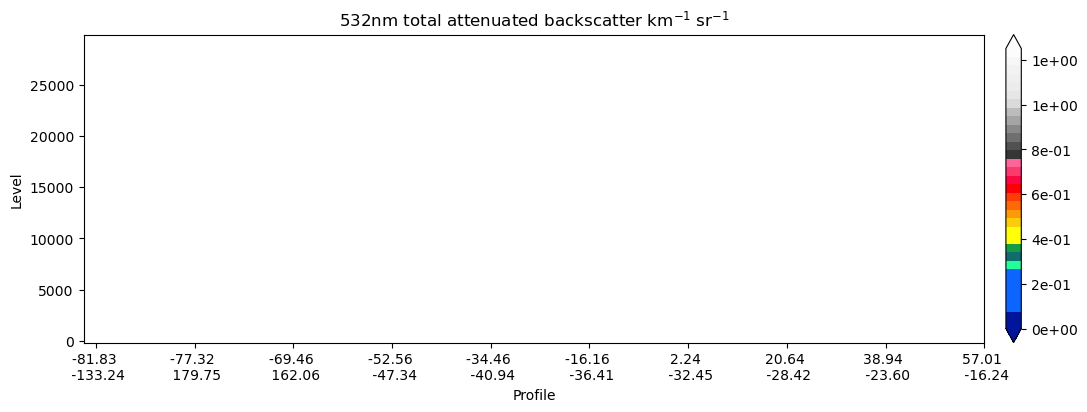

In [34]:
p = plot_ds.obsv.sel(Channel=0).plot(
    x='Profile',
    cmap=color_map,
    vmin=0.0,
    vmax=1.25,
    size=4,
    aspect=3.5,
    add_colorbar=True,
    cbar_kwargs={
        'format': "%.e",
        'label': None,
        'pad': 0.02
    },
)
p.axes.set_title(r'532nm total attenuated backscatter km$^{-1}$ sr$^{-1}$')
p.axes.set_xticks(xvals)
p.axes.set_xticklabels(xstrs)

[Text(20518, 0, '-81.83 \n -133.24'),
 Text(183361, 0, '-77.32 \n 179.75'),
 Text(346205, 0, '-69.46 \n 162.06'),
 Text(509049, 0, '-52.56 \n -47.34'),
 Text(671893, 0, '-34.46 \n -40.94'),
 Text(834737, 0, '-16.16 \n -36.41'),
 Text(997581, 0, '2.24 \n -32.45'),
 Text(1160425, 0, '20.64 \n -28.42'),
 Text(1323269, 0, '38.94 \n -23.60'),
 Text(1486113, 0, '57.01 \n -16.24')]

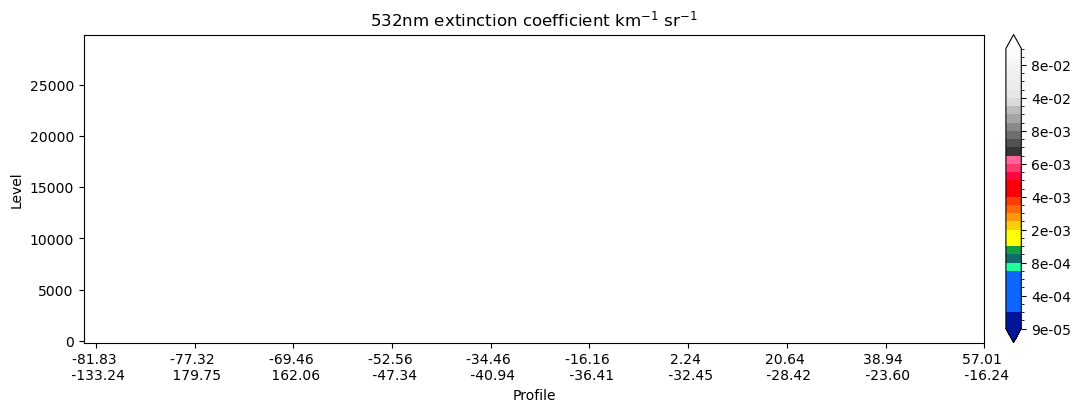

In [71]:
p = plot_ds['obsv'].sel(Channel=1).plot(
    x='Profile',
    cmap=color_map,
    levels=caliop_bound_flt_lst,
    size=4,
    aspect=3.5,
    add_colorbar=True,
    cbar_kwargs={
        'format': "%.e",
        'label': None,
        'pad': 0.02
    },
)
p.axes.set_title(r'532nm extinction coefficient km$^{-1}$ sr$^{-1}$')
p.axes.set_xticks(xvals)
p.axes.set_xticklabels(xstrs)

In [50]:
p.figure.savefig('caliop_l1b_hofx.png', dpi=300)

In [51]:
ncfile = '/glade/derecho/scratch/swei/jpss-simcaliop-out2/AOD/aod.2019072203.nc'
ds = xa.open_dataset(ncfile)

In [62]:
proj = ccrs.PlateCarree()
c_lon = plot_ds.lon.mean().data
c_lat = plot_ds.lat.mean().data

In [70]:
plot_ds.lon.data

array([-15.48911 , -15.490871, -15.492632, ..., -30.647308, -30.647976,
       -30.64864 ], dtype=float32)

In [55]:
colors = ["white", "tab:orange", "black"]
n_bins = 100
cmap = LinearSegmentedColormap.from_list('here', colors, N=n_bins)

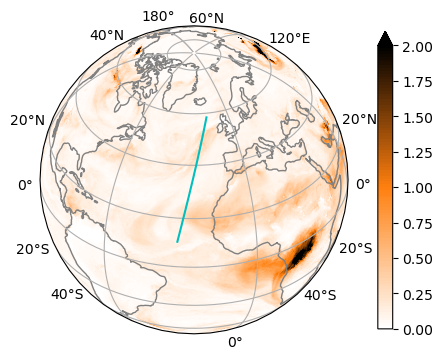

In [95]:
p = ds.aod.sel(nt=0).plot(
    vmin=0,
    vmax=2,
    size=4,
    aspect=1.6,
    add_colorbar=True,
    subplot_kws=dict(
        projection=ccrs.Orthographic(c_lon, c_lat),
    ),
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    cbar_kwargs=dict(
        label=None,
        pad=0.06,
        fraction=0.03,
    ),
)
p.axes.gridlines(draw_labels=True)
p.axes.coastlines(color='grey')
plt.plot(plot_ds.lon.data[::2000], plot_ds.lat.data[::2000], 'c', ls='-', lw=1.5, marker='', zorder=5, transform=ccrs.PlateCarree())

In [96]:
p.figure.savefig('caliop_path.png', dpi=300)